In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
ntuple = "/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag/NMSSM/NMSSM_XYH_YToHH_6b_MX_1000_MY_600/ntuple.root"
model = "/uscms/home/srosenzw/nobackup/workarea/higgs/sixb_analysis/CMSSW_10_6_19_patch2/src/sixb/weaver-multiH/weaver/models/exp_xy/XY_3H_reco_ranker/20230213_ranger_lr0.0047_batch1024__full_reco_withbkg/"

In [4]:
tree = Tree(ntuple)

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


In [5]:
import awkward0 as ak0

def load_sixb_weaver(t, model, fields=['scores']):
    model = f'{model}/predict_output/{t.sample}.awkd'

    with ak0.load(model) as f_ak:
        fields = {
            field:np.concatenate([ np.array(f_ak[field], dtype=float) ])
            for field in fields
        }
    return fields


In [26]:
def load_yh_trih_ranker(tree, model):
    ranker = load_sixb_weaver(tree, model, fields=['maxcomb','maxlabel','maxscore'])
    score, index, label = ranker['maxscore'], ranker['maxcomb'], ranker['maxlabel']

    index = np.stack([index[:,::2], index[:, 1::2]], axis=2)
    jet_index = ak.from_regular(index.astype(int))
    jets = get_collection(tree, 'jet', named=False)
    
    build_all_dijets(tree, pairs=jet_index, name='higgs', ordered='pt')
    tree.extend(yh_trih_score=score, yy_trih_label=label)
    higgs = get_collection(tree, 'higgs', named=False)
    hp4 = build_p4(higgs)

    h_idx = ak.argsort((higgs.localId+1)//2,axis=-1)

    hx_idx = h_idx[:,:1]
    h1_idx = h_idx[:,1:2]
    h2_idx = h_idx[:,2:]
    hx = hp4[hx_idx][:,0]
    h1 = hp4[h1_idx][:,0]
    h2 = hp4[h2_idx][:,0]

    y_p4 = h1 + h2
    higgs_dr = calc_dr_p4(h1, h2)
    y = dict(
        m=y_p4.m,
        pt=y_p4.pt,
        eta=y_p4.eta,
        phi=y_p4.phi,
        higgs_dr=higgs_dr,
        h1Idx=h1_idx,
        h2Idx=h2_idx,
    )
    tree.extend(
        **{
            f'HX_{field}': hx[field]
            for field in hx.fields

        },
        **{
            f'H1_{field}': h1[field]
            for field in h1.fields

        },
        **{
            f'H2_{field}': h2[field]
            for field in h2.fields

        },
        **{
            f'Y_{field}':array
            for field, array in y.items()
        }
    )

In [28]:
ranker = load_sixb_weaver(tree, model, fields=['maxscore','maxcomb','maxlabel'])

In [43]:
combos = ak.from_regular(ranker['maxcomb'].astype(int))

In [65]:
jets = get_collection(tree, 'jet', named=False)
jet_p4 = build_p4(jets, use_regressed=True)

In [83]:
jet_p4 = jet_p4[combos]

In [84]:
hx_b1 = jet_p4[:,0]
hx_b2 = jet_p4[:,1]
h1_b1 = jet_p4[:,2]
h1_b2 = jet_p4[:,3]
h2_b1 = jet_p4[:,4]
h2_b2 = jet_p4[:,5]


In [85]:
h1 = h1_b1 + h1_b2
h2 = h2_b1 + h2_b2

In [86]:
y = h1 + h2

(<Figure size 650x650 with 1 Axes>,
 <AxesSubplot:ylabel='Events'>,
 [HistoList<[<utils.plotUtils.histogram.Histo object at 0x7fbf7eebe970>]>])

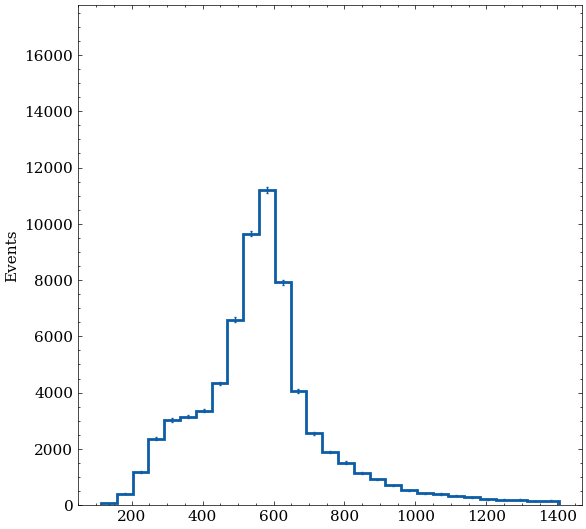

In [90]:
hist_multi([y.m])

In [78]:
h_p4 = j1 + j2

In [79]:
h1, h2 = h_p4[:,1], h_p4[:,2]

In [80]:
y = h1 + h2

(<Figure size 650x650 with 1 Axes>,
 <AxesSubplot:ylabel='Events'>,
 [HistoList<[<utils.plotUtils.histogram.Histo object at 0x7fbf7edc8d30>]>])

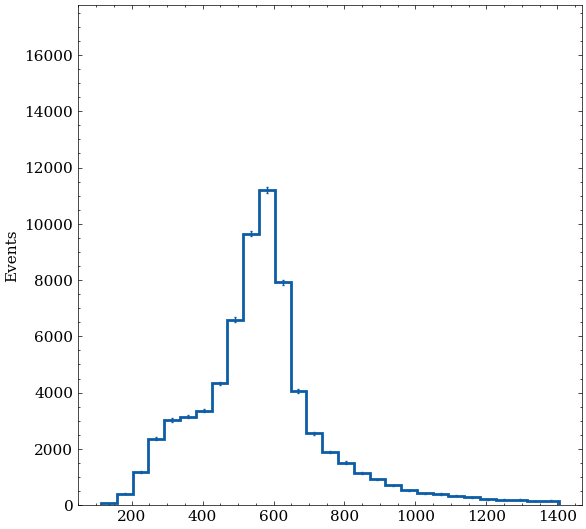

In [81]:
hist_multi([y.m])